# Imports and setup

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision
from torchvision import transforms
from tqdm import tqdm
import math
import sys
import os
import matplotlib.pyplot as plt

In [4]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/master/ml'
else:
    BASE_DIR = '.'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model code

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size=3, stride=1, padding=1, dropout=None,
                 pad_type='zero', dropout_pos='CDBR'):
        super().__init__()
        self.dropout_pos = dropout_pos
        if pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        elif pad_type == 'reflect':
            # [!] the paper used reflect padding - just for data augmentation?
            self.pad = nn.ReflectionPad2d(padding)
        else:
            raise ValueError(pad_type)

        self.conv = nn.Conv2d(C_in, C_out, kernel_size, stride, padding=0, bias=False)
        if dropout is not None and dropout > 0.:
            self.dropout = nn.Dropout2d(p=dropout, inplace=True)
        else:
            self.dropout = None
        self.bn = nn.BatchNorm2d(C_out)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        if self.dropout_pos == 'CDBR' and self.dropout:
            out = self.dropout(out)
        out = self.bn(out)
        out = F.relu_(out)
        if self.dropout_pos == 'CBRD' and self.dropout:
            out = self.dropout(out)

        return out


class FractalBlock(nn.Module):
    def __init__(self, n_columns, C_in, C_out, p_ldrop, p_dropout, pad_type='zero',
                 doubling=False, dropout_pos='CDBR'):
        super().__init__()

        self.n_columns = n_columns
        self.p_ldrop = p_ldrop
        self.dropout_pos = dropout_pos
        if dropout_pos == 'FD' and p_dropout > 0.:
            self.dropout = nn.Dropout2d(p=p_dropout)
            p_dropout = 0.
        else:
            self.dropout = None

        if doubling:
            self.doubler = ConvBlock(C_in, C_out, 1, padding=0)
        else:
            self.doubler = None

        self.columns = nn.ModuleList([nn.ModuleList() for _ in range(n_columns)])
        self.max_depth = 2 ** (n_columns-1)

        dist = self.max_depth
        self.count = np.zeros([self.max_depth], dtype=np.int32)
        for col in self.columns:
            for i in range(self.max_depth):
                if (i+1) % dist == 0:
                    first_block = (i+1 == dist) # first block in this column
                    if first_block and not doubling:
                        # if doubling, always input channel size is C_out.
                        cur_C_in = C_in
                    else:
                        cur_C_in = C_out

                    module = ConvBlock(cur_C_in, C_out, dropout=p_dropout, pad_type=pad_type,
                                       dropout_pos=dropout_pos)
                    self.count[i] += 1
                else:
                    module = None

                col.append(module)

            dist //= 2

    def drop_mask(self, B, global_cols, n_cols):
        # global drop mask
        GB = global_cols.shape[0]
        # calc gdrop cols / samples
        gdrop_cols = global_cols - (self.n_columns - n_cols)
        gdrop_indices = np.where(gdrop_cols >= 0)[0]
        # gen gdrop mask
        gdrop_mask = np.zeros([n_cols, GB], dtype=np.float32)
        gdrop_mask[gdrop_cols[gdrop_indices], gdrop_indices] = 1.

        # local drop mask
        LB = B - GB
        ldrop_mask = np.random.binomial(1, 1.-self.p_ldrop, [n_cols, LB]).astype(np.float32)
        alive_count = ldrop_mask.sum(axis=0)
        dead_indices = np.where(alive_count == 0.)[0]
        ldrop_mask[np.random.randint(0, n_cols, size=dead_indices.shape), dead_indices] = 1.

        drop_mask = np.concatenate((gdrop_mask, ldrop_mask), axis=1)
        return torch.from_numpy(drop_mask)

    def join(self, outs, global_cols):
        n_cols = len(outs)
        out = torch.stack(outs) # [n_cols, B, C, H, W]

        if self.training:
            mask = self.drop_mask(out.size(1), global_cols, n_cols).to(out.device) # [n_cols, B]
            mask = mask.view(*mask.size(), 1, 1, 1) # unsqueeze to [n_cols, B, 1, 1, 1]
            n_alive = mask.sum(dim=0) # [B, 1, 1, 1]
            masked_out = out * mask # [n_cols, B, C, H, W]
            n_alive[n_alive == 0.] = 1. # all-dead cases
            out = masked_out.sum(dim=0) / n_alive # [B, C, H, W] / [B, 1, 1, 1]
        else:
            out = out.mean(dim=0) # no drop

        return out

    def forward(self, x, global_cols, deepest=False):
        out = self.doubler(x) if self.doubler else x
        outs = [out] * self.n_columns
        for i in range(self.max_depth):
            st = self.n_columns - self.count[i]
            cur_outs = [] # outs of current depth
            if deepest:
                st = self.n_columns - 1 # last column only

            for c in range(st, self.n_columns):
                cur_in = outs[c] # current input
                cur_module = self.columns[c][i] # current module
                cur_outs.append(cur_module(cur_in))

            # join
            #print("join in depth = {}, # of in_join = {}".format(i, len(cur_out)))
            joined = self.join(cur_outs, global_cols)

            for c in range(st, self.n_columns):
                outs[c] = joined

        if self.dropout_pos == 'FD' and self.dropout:
            outs[-1] = self.dropout(outs[-1])

        return outs[-1] # for deepest case


class FractalNet(nn.Module):
    def __init__(self, data_shape, n_columns, init_channels, p_ldrop, dropout_probs,
                 gdrop_ratio, gap=0, init='xavier', pad_type='zero', doubling=False,
                 consist_gdrop=True, dropout_pos='CDBR'):
        super().__init__()
        assert dropout_pos in ['CDBR', 'CBRD', 'FD']

        self.B = len(dropout_probs) # the number of blocks
        self.consist_gdrop = consist_gdrop
        self.gdrop_ratio = gdrop_ratio
        self.n_columns = n_columns
        C_in, H, W, n_classes = data_shape

        assert H == W
        size = H

        layers = nn.ModuleList()
        C_out = init_channels
        total_layers = 0
        for b, p_dropout in enumerate(dropout_probs):
            print("[block {}] Channel in = {}, Channel out = {}".format(b, C_in, C_out))
            fb = FractalBlock(n_columns, C_in, C_out, p_ldrop, p_dropout,
                              pad_type=pad_type, doubling=doubling, dropout_pos=dropout_pos)
            layers.append(fb)
            if gap == 0 or b < self.B-1:
                # Originally, every pool is max-pool in the paper (No GAP).
                layers.append(nn.MaxPool2d(2))
            elif gap == 1:
                # last layer and gap == 1
                layers.append(nn.AdaptiveAvgPool2d(1)) # average pooling

            size //= 2
            total_layers += fb.max_depth
            C_in = C_out
            if b < self.B-2:
                C_out *= 2 # doubling except for last block

        print("Last featuremap size = {}".format(size))
        print("Total layers = {}".format(total_layers))

        if gap == 2:
            layers.append(nn.Conv2d(C_out, n_classes, 1, padding=0)) # 1x1 conv
            layers.append(nn.AdaptiveAvgPool2d(1)) # gap
            layers.append(Flatten())
        else:
            layers.append(Flatten())
            layers.append(nn.Linear(C_out * size * size, n_classes)) # fc layer

        self.layers = layers

        # initialization
        if init != 'torch':
            initialize_ = {
                'xavier': nn.init.xavier_uniform_,
                'he': nn.init.kaiming_uniform_
            }[init]

            for n, p in self.named_parameters():
                if p.dim() > 1: # weights only
                    initialize_(p)
                else: # bn w/b or bias
                    if 'bn.weight' in n:
                        nn.init.ones_(p)
                    else:
                        nn.init.zeros_(p)

    def forward(self, x, deepest=False):
        if deepest:
            assert self.training is False
        GB = int(x.size(0) * self.gdrop_ratio)
        out = x
        global_cols = None
        for layer in self.layers:
            if isinstance(layer, FractalBlock):
                if not self.consist_gdrop or global_cols is None:
                    global_cols = np.random.randint(0, self.n_columns, size=[GB])

                out = layer(out, global_cols, deepest=deepest)
            else:
                out = layer(out)

        return out

# Load the data

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

train_val_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_ds, val_ds = torch.utils.data.random_split(train_val_ds, [.9, .1])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13954677.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Create the model

In [ ]:
model = FractalNet(data_shape=(3,32,32,10), n_columns=4, init_channels=64, dropout_probs=[0, .1, .2, .3, .4], gdrop_ratio=.5, p_ldrop=.15, doubling=True, pad_type='reflect')

[block 0] Channel in = 3, Channel out = 64
[block 1] Channel in = 64, Channel out = 128
[block 2] Channel in = 128, Channel out = 256
[block 3] Channel in = 256, Channel out = 512
[block 4] Channel in = 512, Channel out = 512
Last featuremap size = 1
Total layers = 40


# Main training loop

In [ ]:
num_epochs = 50
file_label = 'adam-50-cifar10'

model = model.to(DEVICE)

if os.path.exists(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'):
    model.load_state_dict(torch.load(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'))
    history = torch.load(f'{BASE_DIR}/checkpoints/history-{file_label}.pt')
else:
    history = {
        'loss': [],
        'val_loss': []
    }

num_epochs_completed = len(history['loss'])

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs_completed+1, num_epochs+1):
    with tqdm(train_dl, unit='batch') as tepoch:
        epoch_losses = []
        model.train()
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            correct = (out.argmax(1) == target.argmax(1)).sum().item()
            accuracy = correct / len(target)

            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)
    epoch_mean_loss = sum(epoch_losses) / len(epoch_losses)
    history['loss'].append(epoch_mean_loss)

    with torch.no_grad():
        epoch_val_losses = []
        model.eval()
        for data, target in val_dl:
            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            out = model(data)
            loss = criterion(out, target)
            epoch_val_losses.append(loss.item())
        epoch_mean_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        history['val_loss'].append(epoch_mean_val_loss)

    torch.save(model.state_dict(), f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt')
    torch.save(history, f'{BASE_DIR}/checkpoints/history-{file_label}.pt')

    print(f'done epoch {epoch} with results: loss={epoch_mean_loss}, val_loss={epoch_mean_val_loss}')

Epoch 1: 100%|██████████| 704/704 [00:52<00:00, 13.51batch/s, accuracy=0.125, loss=2.51] 


done epoch 1 with results: loss=2.3448152086612852, val_loss=2.18374714670302


Epoch 2: 100%|██████████| 704/704 [00:50<00:00, 13.84batch/s, accuracy=0, loss=2.48]     


done epoch 2 with results: loss=2.057756345549768, val_loss=2.021042850953114


Epoch 3: 100%|██████████| 704/704 [00:52<00:00, 13.54batch/s, accuracy=0.125, loss=2.67] 


done epoch 3 with results: loss=1.9710481395436958, val_loss=1.8749755545507503


Epoch 4: 100%|██████████| 704/704 [00:51<00:00, 13.79batch/s, accuracy=0.5, loss=1.55]  


done epoch 4 with results: loss=1.8851546006785198, val_loss=1.8265948220144343


Epoch 5: 100%|██████████| 704/704 [00:50<00:00, 13.86batch/s, accuracy=0.25, loss=1.9]  


done epoch 5 with results: loss=1.8035791778767651, val_loss=1.6485697317727004


Epoch 6: 100%|██████████| 704/704 [00:50<00:00, 14.01batch/s, accuracy=0.25, loss=1.81] 


done epoch 6 with results: loss=1.7353116588836366, val_loss=1.5443047888671295


Epoch 7: 100%|██████████| 704/704 [00:52<00:00, 13.41batch/s, accuracy=0.375, loss=1.62]


done epoch 7 with results: loss=1.656755476004698, val_loss=1.4545998784560192


Epoch 8: 100%|██████████| 704/704 [00:52<00:00, 13.48batch/s, accuracy=0.5, loss=1.49]  


done epoch 8 with results: loss=1.596541621468284, val_loss=1.4745576909825773


Epoch 9: 100%|██████████| 704/704 [00:50<00:00, 13.87batch/s, accuracy=0.25, loss=1.99] 


done epoch 9 with results: loss=1.5412865304811434, val_loss=1.3860403872743439


Epoch 10: 100%|██████████| 704/704 [00:50<00:00, 13.85batch/s, accuracy=0.375, loss=1.5] 


done epoch 10 with results: loss=1.4844796567816625, val_loss=1.2438869853562946


Epoch 11: 100%|██████████| 704/704 [00:50<00:00, 13.90batch/s, accuracy=0.375, loss=1.49]


done epoch 11 with results: loss=1.430091472173279, val_loss=1.189201001125046


Epoch 12: 100%|██████████| 704/704 [00:50<00:00, 13.85batch/s, accuracy=0.125, loss=2.08]


done epoch 12 with results: loss=1.372490807859735, val_loss=1.178942629808112


Epoch 13: 100%|██████████| 704/704 [00:52<00:00, 13.41batch/s, accuracy=0.625, loss=1.76] 


done epoch 13 with results: loss=1.320134736089544, val_loss=1.0824062643171866


Epoch 14: 100%|██████████| 704/704 [00:51<00:00, 13.70batch/s, accuracy=0.375, loss=1.78] 


done epoch 14 with results: loss=1.2741520808671007, val_loss=0.9668427766123905


Epoch 15: 100%|██████████| 704/704 [00:51<00:00, 13.65batch/s, accuracy=0.375, loss=3.28] 


done epoch 15 with results: loss=1.238149680197239, val_loss=0.9222342047510268


Epoch 16: 100%|██████████| 704/704 [00:52<00:00, 13.30batch/s, accuracy=0.125, loss=3.93] 


done epoch 16 with results: loss=1.2005157824605703, val_loss=0.9160391394096085


Epoch 17: 100%|██████████| 704/704 [00:51<00:00, 13.80batch/s, accuracy=0.25, loss=1.74]  


done epoch 17 with results: loss=1.1686165361580523, val_loss=0.9036607432969009


Epoch 18: 100%|██████████| 704/704 [00:51<00:00, 13.78batch/s, accuracy=0.625, loss=1.1]  


done epoch 18 with results: loss=1.1254838329993866, val_loss=0.8247771549828445


Epoch 19: 100%|██████████| 704/704 [00:52<00:00, 13.47batch/s, accuracy=0.375, loss=2.19] 


done epoch 19 with results: loss=1.0950964479283853, val_loss=0.8110028263888781


Epoch 20: 100%|██████████| 704/704 [00:52<00:00, 13.43batch/s, accuracy=0.5, loss=1.5]    


done epoch 20 with results: loss=1.06627243460918, val_loss=0.7683475681498081


Epoch 21: 100%|██████████| 704/704 [00:53<00:00, 13.15batch/s, accuracy=0.625, loss=1.45] 


done epoch 21 with results: loss=1.0522566010159524, val_loss=0.7896854017354265


Epoch 22: 100%|██████████| 704/704 [00:54<00:00, 12.93batch/s, accuracy=0.75, loss=0.876] 


done epoch 22 with results: loss=1.011689567345787, val_loss=0.7108049766172336


Epoch 23: 100%|██████████| 704/704 [00:52<00:00, 13.42batch/s, accuracy=0.375, loss=2.56] 


done epoch 23 with results: loss=0.9966350643133576, val_loss=0.6886016130447388


Epoch 24: 100%|██████████| 704/704 [00:52<00:00, 13.52batch/s, accuracy=0.625, loss=1.44] 


done epoch 24 with results: loss=0.9713705955919895, val_loss=0.6673706909523734


Epoch 25: 100%|██████████| 704/704 [00:52<00:00, 13.46batch/s, accuracy=0.5, loss=0.86]   


done epoch 25 with results: loss=0.9481534758074717, val_loss=0.6659052775630468


Epoch 26: 100%|██████████| 704/704 [00:52<00:00, 13.54batch/s, accuracy=0.625, loss=1.45] 


done epoch 26 with results: loss=0.922534991055727, val_loss=0.6422026628934885


Epoch 27: 100%|██████████| 704/704 [00:52<00:00, 13.52batch/s, accuracy=0.375, loss=1.38] 


done epoch 27 with results: loss=0.9074548560787331, val_loss=0.690162715089472


Epoch 28: 100%|██████████| 704/704 [00:51<00:00, 13.75batch/s, accuracy=0.625, loss=1.02] 


done epoch 28 with results: loss=0.8916839765046131, val_loss=0.6097801810578455


Epoch 29: 100%|██████████| 704/704 [00:50<00:00, 13.94batch/s, accuracy=0.625, loss=2.32] 


done epoch 29 with results: loss=0.8658941024914384, val_loss=0.5821946636785434


Epoch 30: 100%|██████████| 704/704 [00:51<00:00, 13.56batch/s, accuracy=0.625, loss=1.39] 


done epoch 30 with results: loss=0.8468260453929278, val_loss=0.5907765517506418


Epoch 31: 100%|██████████| 704/704 [00:52<00:00, 13.51batch/s, accuracy=0.625, loss=1.26] 


done epoch 31 with results: loss=0.8375489291396331, val_loss=0.5758595425116865


Epoch 32: 100%|██████████| 704/704 [00:50<00:00, 13.92batch/s, accuracy=0.5, loss=1.73]   


done epoch 32 with results: loss=0.8180258465422825, val_loss=0.5772029704685453


Epoch 33: 100%|██████████| 704/704 [00:53<00:00, 13.20batch/s, accuracy=0.5, loss=1.36]   


done epoch 33 with results: loss=0.8022606007924135, val_loss=0.5421543611755854


Epoch 34: 100%|██████████| 704/704 [00:54<00:00, 12.94batch/s, accuracy=0.375, loss=1.87] 


done epoch 34 with results: loss=0.7886430243538185, val_loss=0.529790635161762


Epoch 35: 100%|██████████| 704/704 [00:54<00:00, 12.99batch/s, accuracy=0.375, loss=2.41] 


done epoch 35 with results: loss=0.7787354472093284, val_loss=0.5256614967992034


Epoch 36: 100%|██████████| 704/704 [00:54<00:00, 12.99batch/s, accuracy=0.625, loss=0.983]


done epoch 36 with results: loss=0.7560516484505073, val_loss=0.5259100904193106


Epoch 37: 100%|██████████| 704/704 [00:53<00:00, 13.10batch/s, accuracy=0.625, loss=2.68] 


done epoch 37 with results: loss=0.7526959451762113, val_loss=0.5009150046713745


Epoch 38: 100%|██████████| 704/704 [00:52<00:00, 13.31batch/s, accuracy=0.75, loss=0.641] 


done epoch 38 with results: loss=0.7371998209167611, val_loss=0.520189848504489


Epoch 39: 100%|██████████| 704/704 [00:52<00:00, 13.34batch/s, accuracy=0.625, loss=1.01] 


done epoch 39 with results: loss=0.7254467635330829, val_loss=0.5192214469366436


Epoch 40: 100%|██████████| 704/704 [00:54<00:00, 12.99batch/s, accuracy=0.5, loss=0.88]   


done epoch 40 with results: loss=0.7139741745777428, val_loss=0.4880635730827911


Epoch 41: 100%|██████████| 704/704 [00:53<00:00, 13.06batch/s, accuracy=0.75, loss=1.3]   


done epoch 41 with results: loss=0.7022947768934749, val_loss=0.48525593288337127


Epoch 42: 100%|██████████| 704/704 [00:53<00:00, 13.22batch/s, accuracy=0.75, loss=0.3]   


done epoch 42 with results: loss=0.6830232667906041, val_loss=0.4680352422255504


Epoch 43: 100%|██████████| 704/704 [00:51<00:00, 13.71batch/s, accuracy=0.625, loss=1.66] 


done epoch 43 with results: loss=0.6799747786399993, val_loss=0.48836660950998717


Epoch 44: 100%|██████████| 704/704 [00:52<00:00, 13.44batch/s, accuracy=0.75, loss=0.593] 


done epoch 44 with results: loss=0.6609574715945531, val_loss=0.4649678861038594


Epoch 45: 100%|██████████| 704/704 [00:52<00:00, 13.32batch/s, accuracy=0.875, loss=0.876]


done epoch 45 with results: loss=0.6488283248618245, val_loss=0.46467755885818335


Epoch 46: 100%|██████████| 704/704 [00:51<00:00, 13.70batch/s, accuracy=0.625, loss=1.08] 


done epoch 46 with results: loss=0.6436430973593484, val_loss=0.45449912623514105


Epoch 47: 100%|██████████| 704/704 [00:52<00:00, 13.44batch/s, accuracy=0.875, loss=0.227]


done epoch 47 with results: loss=0.627423993946815, val_loss=0.4614124894142151


Epoch 48: 100%|██████████| 704/704 [00:52<00:00, 13.34batch/s, accuracy=0.875, loss=0.686]


done epoch 48 with results: loss=0.6182344722222876, val_loss=0.443414298416693


Epoch 49: 100%|██████████| 704/704 [00:53<00:00, 13.18batch/s, accuracy=0.75, loss=0.982] 


done epoch 49 with results: loss=0.612089383373545, val_loss=0.42861173462264146


Epoch 50: 100%|██████████| 704/704 [00:52<00:00, 13.36batch/s, accuracy=0.75, loss=1.08]  


done epoch 50 with results: loss=0.6029528432356362, val_loss=0.439981876860691


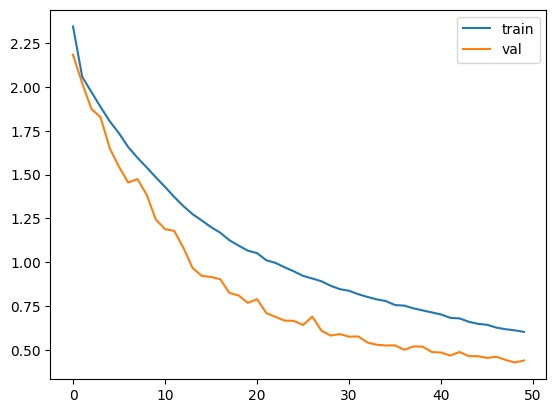

In [ ]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')

plt.legend()

plt.show()

In [ ]:
test_losses = []
test_acc = []
with torch.no_grad():
    model = model.eval()
    for data, label in test_dl:
        data, label = data.to(DEVICE), F.one_hot(label, 10).float().to(DEVICE)
        out = model(data)

        loss = criterion(out, label)
        test_losses.append(loss.item())

        correct = (out.argmax(1) == label.argmax(1)).sum().item()
        accuracy = correct / len(label)
        test_acc.append(accuracy)

sum(test_losses) / len(test_losses), sum(test_acc) / len(test_acc)

(0.4413763201160795, 0.8484275477707006)

# Try with GAP

In [7]:
model = FractalNet(data_shape=(3,32,32,10), n_columns=4, init_channels=64, dropout_probs=[0, .1, .2, .3, .4], gdrop_ratio=.5, p_ldrop=.15, gap=2)

num_epochs = 50
file_label = 'adam-50-cifar10-gap'

model = model.to(DEVICE)

if os.path.exists(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'):
    model.load_state_dict(torch.load(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'))
    history = torch.load(f'{BASE_DIR}/checkpoints/history-{file_label}.pt')
else:
    history = {
        'loss': [],
        'val_loss': []
    }

num_epochs_completed = len(history['loss'])

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs_completed+1, num_epochs+1):
    with tqdm(train_dl, unit='batch') as tepoch:
        epoch_losses = []
        model.train()
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            correct = (out.argmax(1) == target.argmax(1)).sum().item()
            accuracy = correct / len(target)

            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)
    epoch_mean_loss = sum(epoch_losses) / len(epoch_losses)
    history['loss'].append(epoch_mean_loss)

    with torch.no_grad():
        epoch_val_losses = []
        model.eval()
        for data, target in val_dl:
            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            out = model(data)
            loss = criterion(out, target)
            epoch_val_losses.append(loss.item())
        epoch_mean_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        history['val_loss'].append(epoch_mean_val_loss)

    torch.save(model.state_dict(), f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt')
    torch.save(history, f'{BASE_DIR}/checkpoints/history-{file_label}.pt')

    print(f'done epoch {epoch} with results: loss={epoch_mean_loss}, val_loss={epoch_mean_val_loss}')

[block 0] Channel in = 3, Channel out = 64
[block 1] Channel in = 64, Channel out = 128
[block 2] Channel in = 128, Channel out = 256
[block 3] Channel in = 256, Channel out = 512
[block 4] Channel in = 512, Channel out = 512
Last featuremap size = 1
Total layers = 40


Epoch 1: 100%|██████████| 704/704 [00:38<00:00, 18.51batch/s, accuracy=0.125, loss=2.59] 


done epoch 1 with results: loss=2.263204485855319, val_loss=2.3093143656283996


Epoch 2: 100%|██████████| 704/704 [00:36<00:00, 19.10batch/s, accuracy=0.25, loss=1.95]  


done epoch 2 with results: loss=2.07016288573769, val_loss=2.0085264127465745


Epoch 3: 100%|██████████| 704/704 [00:36<00:00, 19.12batch/s, accuracy=0.125, loss=1.92]


done epoch 3 with results: loss=1.9201450669630007, val_loss=1.9425180229959609


Epoch 4: 100%|██████████| 704/704 [00:36<00:00, 19.03batch/s, accuracy=0.25, loss=1.58] 


done epoch 4 with results: loss=1.855070192705501, val_loss=1.8547535817834395


Epoch 5: 100%|██████████| 704/704 [00:37<00:00, 18.94batch/s, accuracy=0.5, loss=1.61]  


done epoch 5 with results: loss=1.803309264677492, val_loss=1.8008879543859748


Epoch 6: 100%|██████████| 704/704 [00:36<00:00, 19.05batch/s, accuracy=0.25, loss=2.21] 


done epoch 6 with results: loss=1.7240474039519376, val_loss=1.6760776299464553


Epoch 7: 100%|██████████| 704/704 [00:36<00:00, 19.45batch/s, accuracy=0.25, loss=1.55] 


done epoch 7 with results: loss=1.6388705662367018, val_loss=1.5536769206010843


Epoch 8: 100%|██████████| 704/704 [00:36<00:00, 19.31batch/s, accuracy=0.5, loss=1.4]   


done epoch 8 with results: loss=1.5857182841070674, val_loss=1.5692776441574097


Epoch 9: 100%|██████████| 704/704 [00:36<00:00, 19.51batch/s, accuracy=0.375, loss=1.62]


done epoch 9 with results: loss=1.5241180411116644, val_loss=1.5433041898510125


Epoch 10: 100%|██████████| 704/704 [00:36<00:00, 19.20batch/s, accuracy=0.375, loss=1.53]


done epoch 10 with results: loss=1.4714368729090148, val_loss=1.3794742219055756


Epoch 11: 100%|██████████| 704/704 [00:36<00:00, 19.35batch/s, accuracy=0.5, loss=1.88]  


done epoch 11 with results: loss=1.421016268262809, val_loss=1.3349186891241918


Epoch 12: 100%|██████████| 704/704 [00:36<00:00, 19.45batch/s, accuracy=0.375, loss=1.38] 


done epoch 12 with results: loss=1.3621836302971297, val_loss=1.235157184962985


Epoch 13: 100%|██████████| 704/704 [00:37<00:00, 18.95batch/s, accuracy=0.625, loss=1.75] 


done epoch 13 with results: loss=1.311685825613412, val_loss=1.1124377122408227


Epoch 14: 100%|██████████| 704/704 [00:36<00:00, 19.16batch/s, accuracy=0.625, loss=0.872]


done epoch 14 with results: loss=1.260409127412872, val_loss=1.1477912204175056


Epoch 15: 100%|██████████| 704/704 [00:36<00:00, 19.41batch/s, accuracy=0.5, loss=1.85]   


done epoch 15 with results: loss=1.2146325826814228, val_loss=1.050548471981966


Epoch 16: 100%|██████████| 704/704 [00:36<00:00, 19.36batch/s, accuracy=0.125, loss=2.26] 


done epoch 16 with results: loss=1.1766452562402596, val_loss=0.9849200248718262


Epoch 17: 100%|██████████| 704/704 [00:36<00:00, 19.13batch/s, accuracy=0.5, loss=1.44]   


done epoch 17 with results: loss=1.1372200934724375, val_loss=0.966818755940546


Epoch 18: 100%|██████████| 704/704 [00:36<00:00, 19.11batch/s, accuracy=0.25, loss=0.968] 


done epoch 18 with results: loss=1.1084444012323564, val_loss=0.9486566932895516


Epoch 19: 100%|██████████| 704/704 [00:36<00:00, 19.17batch/s, accuracy=0.625, loss=1.1]  


done epoch 19 with results: loss=1.0715408555485986, val_loss=0.8984004078032095


Epoch 20: 100%|██████████| 704/704 [00:37<00:00, 19.02batch/s, accuracy=0.625, loss=1.14] 


done epoch 20 with results: loss=1.04431228636002, val_loss=0.8610494283935691


Epoch 21: 100%|██████████| 704/704 [00:36<00:00, 19.16batch/s, accuracy=0.75, loss=0.695] 


done epoch 21 with results: loss=1.0085091360590674, val_loss=0.8310554676418063


Epoch 22: 100%|██████████| 704/704 [00:36<00:00, 19.07batch/s, accuracy=0.5, loss=1.38]   


done epoch 22 with results: loss=0.9916464663534001, val_loss=0.8113732171964042


Epoch 23: 100%|██████████| 704/704 [00:36<00:00, 19.05batch/s, accuracy=0.625, loss=0.979]


done epoch 23 with results: loss=0.9654793964529579, val_loss=0.7649637253224095


Epoch 24: 100%|██████████| 704/704 [00:37<00:00, 18.95batch/s, accuracy=0.375, loss=1.95] 


done epoch 24 with results: loss=0.9441735833375291, val_loss=0.7556112680254103


Epoch 25: 100%|██████████| 704/704 [00:36<00:00, 19.11batch/s, accuracy=0.75, loss=1.06]  


done epoch 25 with results: loss=0.9231053810058669, val_loss=0.733603638561466


Epoch 26: 100%|██████████| 704/704 [00:36<00:00, 19.20batch/s, accuracy=1, loss=0.245]    


done epoch 26 with results: loss=0.900328338061544, val_loss=0.7258681949180893


Epoch 27: 100%|██████████| 704/704 [00:36<00:00, 19.29batch/s, accuracy=0.625, loss=1.17] 


done epoch 27 with results: loss=0.8866720545020971, val_loss=0.701165149106255


Epoch 28: 100%|██████████| 704/704 [00:37<00:00, 18.81batch/s, accuracy=0.625, loss=1.4]  


done epoch 28 with results: loss=0.8605822820893743, val_loss=0.6704189532165286


Epoch 29: 100%|██████████| 704/704 [00:37<00:00, 18.90batch/s, accuracy=0.75, loss=0.602] 


done epoch 29 with results: loss=0.8473866699178788, val_loss=0.6838789080517201


Epoch 30: 100%|██████████| 704/704 [00:36<00:00, 19.06batch/s, accuracy=0.75, loss=0.887] 


done epoch 30 with results: loss=0.8264998232268475, val_loss=0.6625815980796572


Epoch 31: 100%|██████████| 704/704 [00:37<00:00, 18.92batch/s, accuracy=0.875, loss=0.468]


done epoch 31 with results: loss=0.8077161184258081, val_loss=0.6549821903433981


Epoch 32: 100%|██████████| 704/704 [00:36<00:00, 19.19batch/s, accuracy=0.625, loss=1.04] 


done epoch 32 with results: loss=0.7913306016813625, val_loss=0.6451644531533688


Epoch 33: 100%|██████████| 704/704 [00:36<00:00, 19.14batch/s, accuracy=0.625, loss=0.995]


done epoch 33 with results: loss=0.7718472972258248, val_loss=0.6270612953584406


Epoch 34: 100%|██████████| 704/704 [00:36<00:00, 19.13batch/s, accuracy=0.5, loss=1.42]   


done epoch 34 with results: loss=0.7577959894287315, val_loss=0.612760796199871


Epoch 35: 100%|██████████| 704/704 [00:36<00:00, 19.08batch/s, accuracy=0.375, loss=1.87] 


done epoch 35 with results: loss=0.7528034585782073, val_loss=0.6081765226170986


Epoch 36: 100%|██████████| 704/704 [00:37<00:00, 18.87batch/s, accuracy=0.5, loss=1.91]   


done epoch 36 with results: loss=0.7321520620449022, val_loss=0.5866210724734053


Epoch 37: 100%|██████████| 704/704 [00:36<00:00, 19.26batch/s, accuracy=0.75, loss=0.643] 


done epoch 37 with results: loss=0.724062647797506, val_loss=0.5634767560264732


Epoch 38: 100%|██████████| 704/704 [00:36<00:00, 19.25batch/s, accuracy=0.75, loss=0.837] 


done epoch 38 with results: loss=0.7047114909457212, val_loss=0.586465625446054


Epoch 39: 100%|██████████| 704/704 [00:36<00:00, 19.04batch/s, accuracy=0.75, loss=0.543] 


done epoch 39 with results: loss=0.6968461096032776, val_loss=0.5545002708706674


Epoch 40: 100%|██████████| 704/704 [00:37<00:00, 19.00batch/s, accuracy=1, loss=0.239]    


done epoch 40 with results: loss=0.6842717418701134, val_loss=0.5556369902966898


Epoch 41: 100%|██████████| 704/704 [00:36<00:00, 19.19batch/s, accuracy=0.875, loss=0.231]


done epoch 41 with results: loss=0.674772525798868, val_loss=0.5534314988534662


Epoch 42: 100%|██████████| 704/704 [00:36<00:00, 19.08batch/s, accuracy=0.625, loss=0.912]


done epoch 42 with results: loss=0.6615482852370902, val_loss=0.541353933796098


Epoch 43: 100%|██████████| 704/704 [00:36<00:00, 19.13batch/s, accuracy=0.625, loss=1.36] 


done epoch 43 with results: loss=0.6536539384079251, val_loss=0.5225148189671432


Epoch 44: 100%|██████████| 704/704 [00:36<00:00, 19.09batch/s, accuracy=0.375, loss=1.22] 


done epoch 44 with results: loss=0.6361474189907312, val_loss=0.522677517767194


Epoch 45: 100%|██████████| 704/704 [00:37<00:00, 19.02batch/s, accuracy=0.75, loss=0.848] 


done epoch 45 with results: loss=0.6294728953137316, val_loss=0.5280138548416428


Epoch 46: 100%|██████████| 704/704 [00:36<00:00, 19.06batch/s, accuracy=1, loss=0.277]    


done epoch 46 with results: loss=0.6173637561838735, val_loss=0.5060029618347748


Epoch 47: 100%|██████████| 704/704 [00:37<00:00, 19.02batch/s, accuracy=0.875, loss=0.371]


done epoch 47 with results: loss=0.6035819854587317, val_loss=0.5043257829509203


Epoch 48: 100%|██████████| 704/704 [00:36<00:00, 19.18batch/s, accuracy=0.625, loss=1.15] 


done epoch 48 with results: loss=0.6002339204900305, val_loss=0.4935166217103789


Epoch 49: 100%|██████████| 704/704 [00:36<00:00, 19.08batch/s, accuracy=0.625, loss=0.457]


done epoch 49 with results: loss=0.5854713394391265, val_loss=0.49802826363829117


Epoch 50: 100%|██████████| 704/704 [00:36<00:00, 19.08batch/s, accuracy=0.625, loss=0.849]


done epoch 50 with results: loss=0.5836657564663752, val_loss=0.49117821907695336


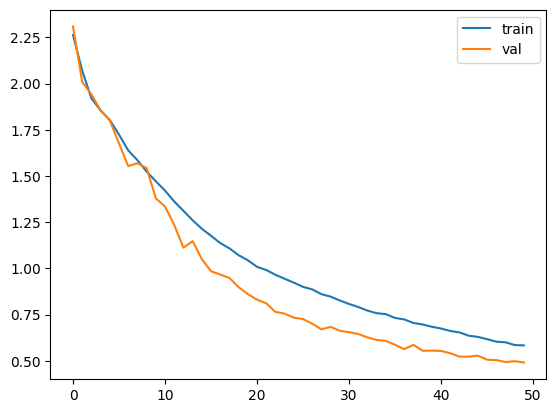

In [8]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')

plt.legend()

plt.show()

In [9]:
test_losses = []
test_acc = []
with torch.no_grad():
    model = model.eval()
    for data, label in test_dl:
        data, label = data.to(DEVICE), F.one_hot(label, 10).float().to(DEVICE)
        out = model(data)

        loss = criterion(out, label)
        test_losses.append(loss.item())

        correct = (out.argmax(1) == label.argmax(1)).sum().item()
        accuracy = correct / len(label)
        test_acc.append(accuracy)

sum(test_losses) / len(test_losses), sum(test_acc) / len(test_acc)

(0.48298849696945995, 0.8359872611464968)

# Trial with old model

In [ ]:
model = FractalNet(data_shape=(3,32,32,10), n_columns=4, init_channels=64, dropout_probs=[0, .1, .2, .3, .4], gdrop_ratio=.5, p_ldrop=.15)

num_epochs = 50
file_label = 'adam-50-cifar10-old'

model = model.to(DEVICE)

if os.path.exists(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'):
    model.load_state_dict(torch.load(f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt'))
    history = torch.load(f'{BASE_DIR}/checkpoints/history-{file_label}.pt')
else:
    history = {
        'loss': [],
        'val_loss': []
    }

num_epochs_completed = len(history['loss'])

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs_completed+1, num_epochs+1):
    with tqdm(train_dl, unit='batch') as tepoch:
        epoch_losses = []
        model.train()
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            correct = (out.argmax(1) == target.argmax(1)).sum().item()
            accuracy = correct / len(target)

            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)
    epoch_mean_loss = sum(epoch_losses) / len(epoch_losses)
    history['loss'].append(epoch_mean_loss)

    with torch.no_grad():
        epoch_val_losses = []
        model.eval()
        for data, target in val_dl:
            data, target = data.to(DEVICE), F.one_hot(target, 10).float().to(DEVICE)
            out = model(data)
            loss = criterion(out, target)
            epoch_val_losses.append(loss.item())
        epoch_mean_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        history['val_loss'].append(epoch_mean_val_loss)

    torch.save(model.state_dict(), f'{BASE_DIR}/checkpoints/savepoint-{file_label}.pt')
    torch.save(history, f'{BASE_DIR}/checkpoints/history-{file_label}.pt')

    print(f'done epoch {epoch} with results: loss={epoch_mean_loss}, val_loss={epoch_mean_val_loss}')

[block 0] Channel in = 3, Channel out = 64
[block 1] Channel in = 64, Channel out = 128
[block 2] Channel in = 128, Channel out = 256
[block 3] Channel in = 256, Channel out = 512
[block 4] Channel in = 512, Channel out = 512
Last featuremap size = 1
Total layers = 40


Epoch 1: 100%|██████████| 704/704 [00:50<00:00, 13.91batch/s, accuracy=0.25, loss=2.41]  


done epoch 1 with results: loss=2.3446805131706325, val_loss=2.325948896287363


Epoch 2: 100%|██████████| 704/704 [00:50<00:00, 14.04batch/s, accuracy=0, loss=2.38]     


done epoch 2 with results: loss=2.176835782825947, val_loss=2.3049853300746483


Epoch 3: 100%|██████████| 704/704 [00:50<00:00, 13.90batch/s, accuracy=0.125, loss=2.18] 


done epoch 3 with results: loss=2.1158294425430624, val_loss=1.9603921009015433


Epoch 4: 100%|██████████| 704/704 [00:50<00:00, 13.97batch/s, accuracy=0.25, loss=2.32]  


done epoch 4 with results: loss=1.9346314023502849, val_loss=1.987938957878306


Epoch 5: 100%|██████████| 704/704 [00:50<00:00, 14.04batch/s, accuracy=0, loss=2.19]    


done epoch 5 with results: loss=1.8785700687969273, val_loss=1.8898133130013188


Epoch 6: 100%|██████████| 704/704 [00:51<00:00, 13.75batch/s, accuracy=0.25, loss=1.9]  


done epoch 6 with results: loss=1.812962321056561, val_loss=1.811229230482367


Epoch 7: 100%|██████████| 704/704 [00:50<00:00, 14.04batch/s, accuracy=0.125, loss=1.37]


done epoch 7 with results: loss=1.726244762201201, val_loss=1.647724471514738


Epoch 8: 100%|██████████| 704/704 [00:50<00:00, 13.99batch/s, accuracy=0.5, loss=1.61]  


done epoch 8 with results: loss=1.6423692156306722, val_loss=1.5420612081696716


Epoch 9: 100%|██████████| 704/704 [00:50<00:00, 14.04batch/s, accuracy=0.125, loss=2.63]


done epoch 9 with results: loss=1.5755464842712337, val_loss=1.4924759894986697


Epoch 10: 100%|██████████| 704/704 [00:49<00:00, 14.33batch/s, accuracy=0.25, loss=2.2]  


done epoch 10 with results: loss=1.5075188675387339, val_loss=1.370739979080007


Epoch 11: 100%|██████████| 704/704 [00:50<00:00, 14.02batch/s, accuracy=0.375, loss=2.19]


done epoch 11 with results: loss=1.4548366225578568, val_loss=1.2932067792626876


Epoch 12: 100%|██████████| 704/704 [00:50<00:00, 13.84batch/s, accuracy=0, loss=2.58]    


done epoch 12 with results: loss=1.396958597173745, val_loss=1.2070841834514956


Epoch 13: 100%|██████████| 704/704 [00:50<00:00, 14.02batch/s, accuracy=0.25, loss=3.1]   


done epoch 13 with results: loss=1.33372484435412, val_loss=1.137497863437556


Epoch 14: 100%|██████████| 704/704 [00:50<00:00, 13.96batch/s, accuracy=0.75, loss=1.57]  


done epoch 14 with results: loss=1.285087082619694, val_loss=1.042551651031156


Epoch 15: 100%|██████████| 704/704 [00:50<00:00, 13.91batch/s, accuracy=0.25, loss=1.59]  


done epoch 15 with results: loss=1.234728820706633, val_loss=0.9923018586786487


Epoch 16: 100%|██████████| 704/704 [00:50<00:00, 13.81batch/s, accuracy=0.375, loss=1.95] 


done epoch 16 with results: loss=1.2041507605463266, val_loss=0.9798310693306259


Epoch 17: 100%|██████████| 704/704 [00:50<00:00, 13.93batch/s, accuracy=0.375, loss=1.59] 


done epoch 17 with results: loss=1.154817389408973, val_loss=0.941652298728122


Epoch 18: 100%|██████████| 704/704 [00:50<00:00, 14.08batch/s, accuracy=0.5, loss=1.07]   


done epoch 18 with results: loss=1.1188763794912533, val_loss=0.8760505922233002


Epoch 19: 100%|██████████| 704/704 [00:50<00:00, 13.91batch/s, accuracy=0.5, loss=1.71]   


done epoch 19 with results: loss=1.0762343933297829, val_loss=0.8452018137219586


Epoch 20: 100%|██████████| 704/704 [00:50<00:00, 14.01batch/s, accuracy=0.75, loss=1.11]  


done epoch 20 with results: loss=1.0422168650918386, val_loss=0.7933750099773649


Epoch 21: 100%|██████████| 704/704 [00:50<00:00, 13.95batch/s, accuracy=0.75, loss=0.472] 


done epoch 21 with results: loss=1.0135752872817896, val_loss=0.8266463739962517


Epoch 22: 100%|██████████| 704/704 [00:51<00:00, 13.64batch/s, accuracy=0.75, loss=0.948] 


done epoch 22 with results: loss=0.989997677335685, val_loss=0.7539785149731214


Epoch 23: 100%|██████████| 704/704 [00:51<00:00, 13.70batch/s, accuracy=0.625, loss=1.52] 


done epoch 23 with results: loss=0.9571867393837734, val_loss=0.7535150458541098


Epoch 24: 100%|██████████| 704/704 [00:50<00:00, 13.91batch/s, accuracy=0.625, loss=1.27] 


done epoch 24 with results: loss=0.9350957488641143, val_loss=0.7413837245748013


Epoch 25: 100%|██████████| 704/704 [00:50<00:00, 14.03batch/s, accuracy=0.5, loss=1.4]    


done epoch 25 with results: loss=0.9256594615395773, val_loss=0.7214588696443582


Epoch 26: 100%|██████████| 704/704 [00:50<00:00, 13.98batch/s, accuracy=0.75, loss=1.34]  


done epoch 26 with results: loss=0.9041579247198321, val_loss=0.7084875574594811


Epoch 27: 100%|██████████| 704/704 [00:49<00:00, 14.35batch/s, accuracy=0.75, loss=0.863] 


done epoch 27 with results: loss=0.8752918898720633, val_loss=0.6584800168683257


Epoch 28: 100%|██████████| 704/704 [00:49<00:00, 14.21batch/s, accuracy=0.75, loss=1.03]  


done epoch 28 with results: loss=0.8574260079555891, val_loss=0.6379165294804151


Epoch 29: 100%|██████████| 704/704 [00:50<00:00, 13.92batch/s, accuracy=0.25, loss=1.92]  


done epoch 29 with results: loss=0.8407696462236345, val_loss=0.6440472508533092


Epoch 30: 100%|██████████| 704/704 [00:50<00:00, 13.83batch/s, accuracy=0.5, loss=1.31]   


done epoch 30 with results: loss=0.8283965025435794, val_loss=0.6481346265424656


Epoch 31: 100%|██████████| 704/704 [00:49<00:00, 14.09batch/s, accuracy=0.75, loss=1.11]  


done epoch 31 with results: loss=0.8037424446506933, val_loss=0.6279564315005194


Epoch 32: 100%|██████████| 704/704 [00:50<00:00, 13.95batch/s, accuracy=0.5, loss=2.5]    


done epoch 32 with results: loss=0.8199776813218539, val_loss=0.604925580039809


Epoch 33: 100%|██████████| 704/704 [00:49<00:00, 14.12batch/s, accuracy=0.625, loss=1.68] 


done epoch 33 with results: loss=0.7701324672776867, val_loss=0.5968769068204904


Epoch 34: 100%|██████████| 704/704 [00:52<00:00, 13.47batch/s, accuracy=0.5, loss=2.58]   


done epoch 34 with results: loss=0.7583731555549259, val_loss=0.5994408330585383


Epoch 35: 100%|██████████| 704/704 [00:49<00:00, 14.12batch/s, accuracy=0.625, loss=1.56] 


done epoch 35 with results: loss=0.7424856849353422, val_loss=0.5733513722691355


Epoch 36: 100%|██████████| 704/704 [00:50<00:00, 14.07batch/s, accuracy=0.625, loss=1.13] 


done epoch 36 with results: loss=0.7260217079046097, val_loss=0.5655210086061985


Epoch 37: 100%|██████████| 704/704 [00:50<00:00, 14.00batch/s, accuracy=1, loss=0.184]    


done epoch 37 with results: loss=0.7168604266745123, val_loss=0.5726556876037694


Epoch 38: 100%|██████████| 704/704 [00:51<00:00, 13.72batch/s, accuracy=0.625, loss=0.746]


done epoch 38 with results: loss=0.7027377720329572, val_loss=0.552818589572665


Epoch 39: 100%|██████████| 704/704 [00:49<00:00, 14.25batch/s, accuracy=0.75, loss=0.415] 


done epoch 39 with results: loss=0.6938154329545796, val_loss=0.5393421819692925


Epoch 40: 100%|██████████| 704/704 [00:50<00:00, 13.98batch/s, accuracy=0.75, loss=1.38]  


done epoch 40 with results: loss=0.6865924165414815, val_loss=0.5458610220045983


Epoch 41: 100%|██████████| 704/704 [00:50<00:00, 13.97batch/s, accuracy=0.875, loss=0.427]


done epoch 41 with results: loss=0.6674203795634888, val_loss=0.5039301377874387


Epoch 42: 100%|██████████| 704/704 [00:50<00:00, 13.95batch/s, accuracy=1, loss=0.301]    


done epoch 42 with results: loss=0.6575979158620943, val_loss=0.5177660882472992


Epoch 43: 100%|██████████| 704/704 [00:50<00:00, 13.83batch/s, accuracy=0.875, loss=0.387]


done epoch 43 with results: loss=0.645274961790578, val_loss=0.4966462190392651


Epoch 44: 100%|██████████| 704/704 [00:51<00:00, 13.72batch/s, accuracy=0.75, loss=1.05]  


done epoch 44 with results: loss=0.6406086079183627, val_loss=0.5200832912439033


Epoch 45: 100%|██████████| 704/704 [00:50<00:00, 13.99batch/s, accuracy=0.875, loss=0.221]


done epoch 45 with results: loss=0.6190373116723177, val_loss=0.4884037335839453


Epoch 46: 100%|██████████| 704/704 [00:50<00:00, 13.98batch/s, accuracy=0.5, loss=1]      


done epoch 46 with results: loss=0.6079418042843993, val_loss=0.4872019060804874


Epoch 47: 100%|██████████| 704/704 [00:51<00:00, 13.79batch/s, accuracy=0.375, loss=1.99] 


done epoch 47 with results: loss=0.5964638426137919, val_loss=0.49502958112125156


Epoch 48: 100%|██████████| 704/704 [00:50<00:00, 13.95batch/s, accuracy=0.75, loss=0.491] 


done epoch 48 with results: loss=0.5958042047833177, val_loss=0.4795804691465595


Epoch 49: 100%|██████████| 704/704 [00:50<00:00, 13.97batch/s, accuracy=0.875, loss=0.481]


done epoch 49 with results: loss=0.5868088358335874, val_loss=0.4678383068287674


Epoch 50: 100%|██████████| 704/704 [00:49<00:00, 14.31batch/s, accuracy=0.5, loss=2.49]   


done epoch 50 with results: loss=0.5762503052723001, val_loss=0.4604154587546481


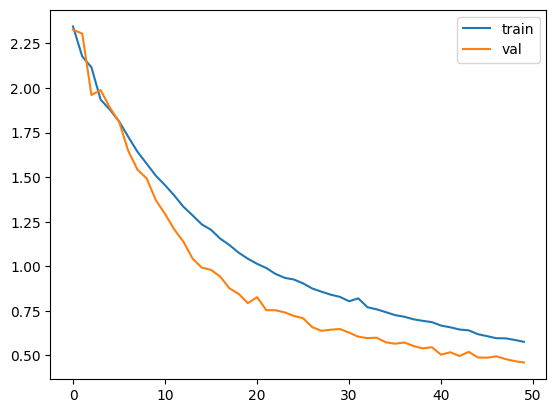

In [ ]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')

plt.legend()

plt.show()

In [ ]:
test_losses = []
test_acc = []
with torch.no_grad():
    model = model.eval()
    for data, label in test_dl:
        data, label = data.to(DEVICE), F.one_hot(label, 10).float().to(DEVICE)
        out = model(data)

        loss = criterion(out, label)
        test_losses.append(loss.item())

        correct = (out.argmax(1) == label.argmax(1)).sum().item()
        accuracy = correct / len(label)
        test_acc.append(accuracy)

sum(test_losses) / len(test_losses), sum(test_acc) / len(test_acc)

(0.47532299920252175, 0.839171974522293)